<a href="https://colab.research.google.com/github/sujitojha1/DataProduct/blob/master/S2_mobilenet_v2_custom_dataset/EVA4_S2_mobilnet_v2_transfer_learning_v4b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Loading Libraries

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
!rm -rf final_images
!wget -q https://github.com/EVA4-RS-Group/Phase2/releases/download/s2/final_images.zip
!unzip -q final_images.zip
!rm -rf /content/__MACOSX
!find /content/final_images/data -name '.DS_Store' -type f -delete

In [39]:
# Load modules/models from EVA course
!rm -rf Modules
!git clone https://github.com/EVA4-RS-Group/Phase2 -q --quiet
!mv ./Phase2/Modules ./Modules
!rm -rf Phase2
#print("Loaded EVA4 Modules")
from Modules import *

In [40]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

  pip install torch-lr-finder -v --global-option="amp"


# 2. Load Data & Set Data Loaders
We will use torchvision and torch.utils.data packages for loading the data.

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [41]:
from Modules import *

In [42]:
split_test_train_data('/content/final_images/data', tstRatio = 0.3)

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']
6761
4165
3653
5673


In [43]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = 'hymenoptera_data'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
#  = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

trnTransform = data_transforms['train'] 
trainSet = DroneDataset(train=True, transform = trnTransform)

tstTransform = data_transforms['val']
testSet = DroneDataset(train= False, transform = tstTransform)

dataloaders = {'train': torch.utils.data.DataLoader(trainSet, batch_size= 192, 
                                                    shuffle=True, num_workers=4),
               'val': torch.utils.data.DataLoader(testSet, batch_size= 192,
                                          shuffle=True, num_workers=4)}

dataset_sizes = {'train': len(trainSet),
                 'val':len(testSet)}

class_names = trainSet.classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']


# 3. Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

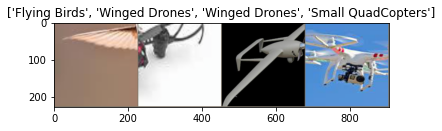

In [47]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:4,:,:,:])

imshow(out, title=[class_names[int(x)] for x in classes[0:4]])

#6. Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


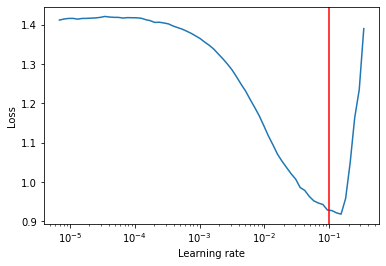

In [51]:
import torch.optim as optim
#from torch_lr_finder import LRFinder

model_ft = models.mobilenet_v2(pretrained=True)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_ft.classifier[1] = nn.Linear(1280, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_ft.classifier[1].parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_ft, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.1) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [55]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.classifier[1].parameters(), lr=0.1, momentum=0.9)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=0.1, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs 
                                          epochs=25)

# 7. Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [56]:
model_res, plotData = train_model(model_ft, dataloaders, dataset_sizes, device, criterion, optimizer_ft, scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.3091 Acc: 0.7247
val Loss: 0.8045 Acc: 0.8126

Epoch 1/24
----------
train Loss: 1.1152 Acc: 0.7343
val Loss: 0.7054 Acc: 0.8032

Epoch 2/24
----------
train Loss: 1.2484 Acc: 0.7228
val Loss: 1.3843 Acc: 0.7658

Epoch 3/24
----------
train Loss: 1.1850 Acc: 0.7371
val Loss: 0.8727 Acc: 0.7961

Epoch 4/24
----------
train Loss: 1.5180 Acc: 0.7125
val Loss: 1.6089 Acc: 0.7637

Epoch 5/24
----------
train Loss: 1.4440 Acc: 0.7211
val Loss: 0.8364 Acc: 0.8111

Epoch 6/24
----------
train Loss: 1.5552 Acc: 0.7196
val Loss: 0.8239 Acc: 0.8031

Epoch 7/24
----------
train Loss: 1.3824 Acc: 0.7236
val Loss: 0.9757 Acc: 0.7927

Epoch 8/24
----------
train Loss: 1.4244 Acc: 0.7244
val Loss: 0.9511 Acc: 0.7904

Epoch 9/24
----------
train Loss: 1.2978 Acc: 0.7314
val Loss: 0.7322 Acc: 0.8110

Epoch 10/24
----------
train Loss: 1.3898 Acc: 0.7206
val Loss: 1.6440 Acc: 0.7054

Epoch 11/24
----------
train Loss: 1.1973 Acc: 0.7346
val Loss: 1.0672 Acc: 0.7614

Epoch 12/24
----------
t

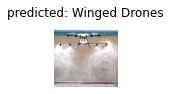

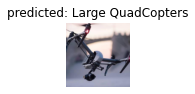

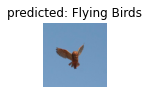

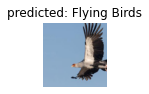

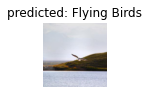

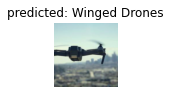

In [57]:
visualize_model(model_res, dataloaders, class_names, device)

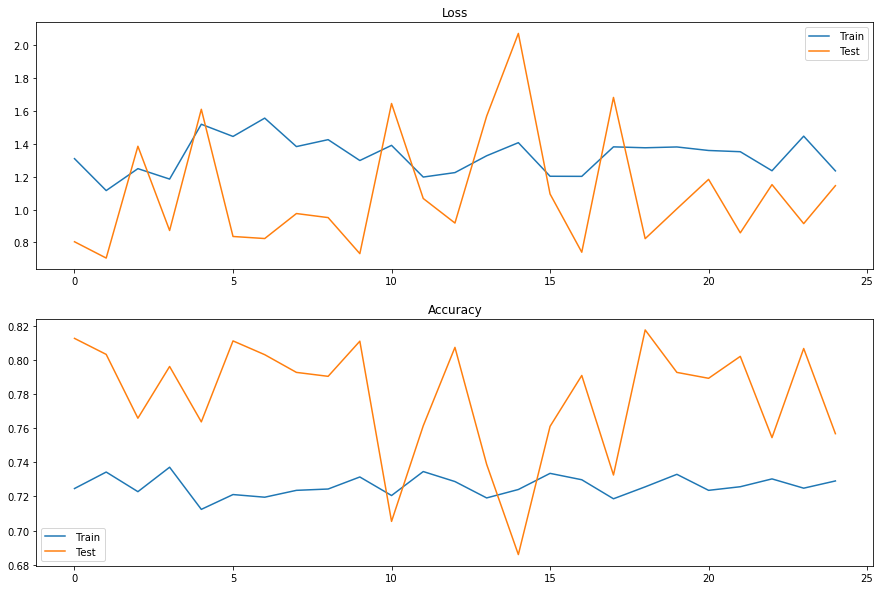

In [58]:
PlotGraph(plotData)

# 8. ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


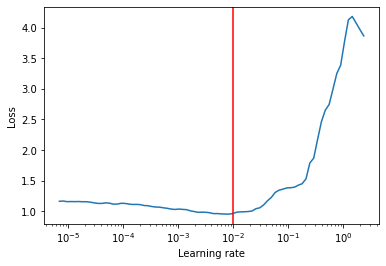

In [59]:
model_conv = model_res
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_conv = model_conv.to(device)

for param in model_conv.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_conv.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_conv, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.01) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [61]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = optim.lr_scheduler.OneCycleLR(optimizer_conv,
                                          max_lr=0.01, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs
                                          epochs=25)

In [62]:
model_final, plotData = train_model(model_conv, dataloaders, dataset_sizes, device, criterion, optimizer_conv, scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8466 Acc: 0.7599
val Loss: 0.4778 Acc: 0.8334

Epoch 1/24
----------
train Loss: 0.6296 Acc: 0.7773
val Loss: 0.4513 Acc: 0.8426

Epoch 2/24
----------
train Loss: 0.5174 Acc: 0.8046
val Loss: 0.3948 Acc: 0.8599

Epoch 3/24
----------
train Loss: 0.4502 Acc: 0.8248
val Loss: 0.3655 Acc: 0.8615

Epoch 4/24
----------
train Loss: 0.4250 Acc: 0.8331
val Loss: 0.3562 Acc: 0.8645

Epoch 5/24
----------
train Loss: 0.3890 Acc: 0.8491
val Loss: 0.3765 Acc: 0.8617

Epoch 6/24
----------
train Loss: 0.3689 Acc: 0.8575
val Loss: 0.3373 Acc: 0.8765

Epoch 7/24
----------
train Loss: 0.3587 Acc: 0.8602
val Loss: 0.3155 Acc: 0.8864

Epoch 8/24
----------
train Loss: 0.3464 Acc: 0.8641
val Loss: 0.3207 Acc: 0.8865

Epoch 9/24
----------
train Loss: 0.3246 Acc: 0.8735
val Loss: 0.3110 Acc: 0.8912

Epoch 10/24
----------
train Loss: 0.3068 Acc: 0.8796
val Loss: 0.3232 Acc: 0.8905

Epoch 11/24
----------
train Loss: 0.3033 Acc: 0.8835
val Loss: 0.3074 Acc: 0.8912

Ep

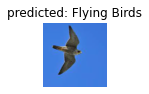

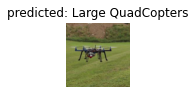

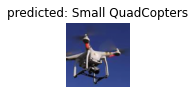

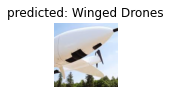

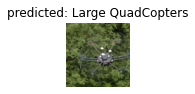

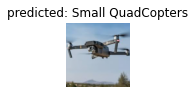

In [63]:
visualize_model(model_final, dataloaders, class_names, device)

plt.ioff()
plt.show()

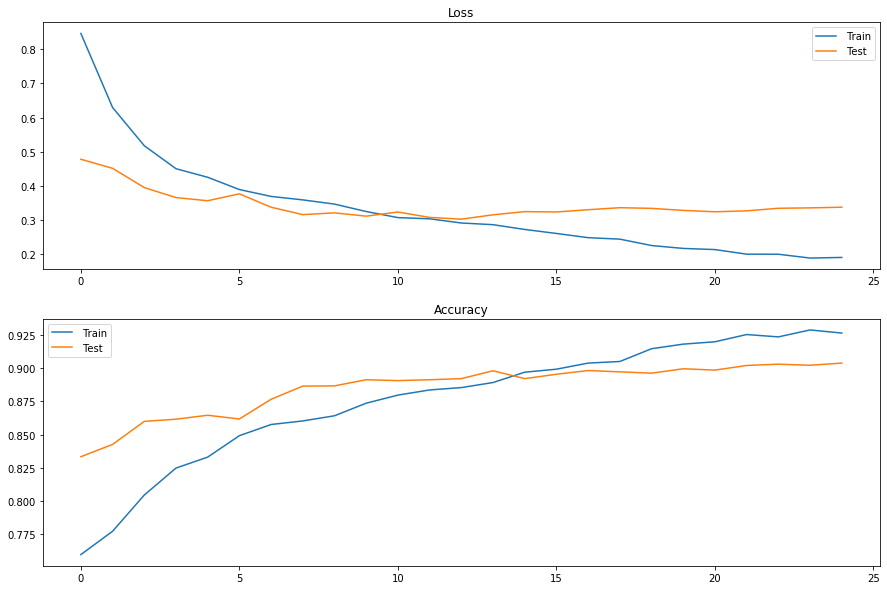

In [64]:
PlotGraph(plotData)

# 9. Saving Model

In [ ]:
# Save GPU Model
torch.save(model_final.state_dict(), '/content/mobilenet_v2_custom_trained_gpu_v4b.pt')

# Load CPU Model
device = torch.device('cpu')
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(1280, 4)
model.load_state_dict(torch.load('/content/mobilenet_v2_custom_trained_gpu_v4b.pt',
                                 map_location=device))

# Saving Trace Model
model.eval()
# trace model with a dummy input
traced_model = torch.jit.trace(model, torch.randn(1, 3, 224, 224))
traced_model.save('mobilenet_v2_custom_trained_v4b.pt')